In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk import FreqDist

In [2]:
# Load the dataset
file_path = 'amazon_cells_labelled.txt'
columns = ['Review', 'Label']
df = pd.read_csv(file_path, sep='\t', header=None, names=columns)

In [3]:
# Display the first few rows of the dataset
print("Original Dataset:")
print(df.head())

Original Dataset:
                                              Review  Label
0  So there is no way for me to plug it in here i...      0
1                        Good case, Excellent value.      1
2                             Great for the jawbone.      1
3  Tied to charger for conversations lasting more...      0
4                                  The mic is great.      1


In [4]:
# Handle missing values
df.dropna(inplace=True)

In [5]:
# Check for missing values
print("Missing values before preprocessing:\n", df.isnull().sum())

Missing values before preprocessing:
 Review    0
Label     0
dtype: int64


In [6]:
# Check class distribution before undersampling
class_distribution_before = df['Label'].value_counts()
print("Class Distribution Before Undersampling:")
print(class_distribution_before)

Class Distribution Before Undersampling:
Label
0    500
1    500
Name: count, dtype: int64


In [7]:
# Undersample the majority class
positive_reviews = df[df['Label'] == 1]
negative_reviews = df[df['Label'] == 0].sample(len(positive_reviews), random_state=42)
df_balanced = pd.concat([positive_reviews, negative_reviews])

In [8]:
# Check class distribution after undersampling
class_distribution_after = df_balanced['Label'].value_counts()
print("\nClass Distribution After Undersampling:")
print(class_distribution_after)


Class Distribution After Undersampling:
Label
1    500
0    500
Name: count, dtype: int64


In [9]:
# Preprocess text
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [10]:
def preprocess_text(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(stemmer.stem(token.lower())) for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

In [11]:
df_balanced['Processed_Review'] = df_balanced['Review'].apply(preprocess_text)

In [12]:
# Construct Term Frequency Matrix
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_balanced['Processed_Review'])
y = df_balanced['Label']

In [13]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Train Naïve Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)

MultinomialNB()

In [15]:
# Evaluate the classifier
y_pred = nb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('Classification Report:\n', classification_report(y_test, y_pred))

Accuracy: 0.745
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.62      0.72       104
           1       0.68      0.88      0.77        96

    accuracy                           0.74       200
   macro avg       0.76      0.75      0.74       200
weighted avg       0.77      0.74      0.74       200



In [16]:
# Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
df_balanced['VADER_Sentiment'] = df_balanced['Review'].apply(lambda x: sia.polarity_scores(x)['compound'])

In [17]:
# Sentiment Analysis using VADER
sia = SentimentIntensityAnalyzer()
df_balanced['VADER_Sentiment'] = df_balanced['Review'].apply(lambda x: sia.polarity_scores(x)['compound'])

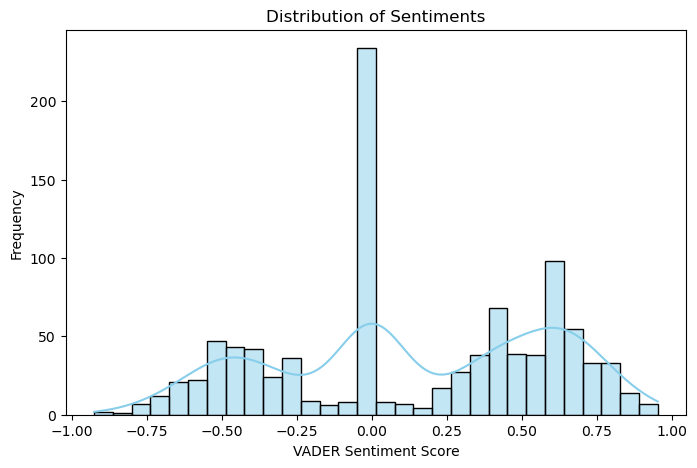

In [18]:
# Plot the distribution of sentiments
plt.figure(figsize=(8, 5))
sns.histplot(df_balanced['VADER_Sentiment'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Sentiments')
plt.xlabel('VADER Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [19]:
# Calculate mean sentiment scores for each class
mean_sentiment_by_class = df_balanced.groupby('Label')['VADER_Sentiment'].mean()

In [20]:
# Display the mean scores
print("Mean Sentiment Scores:")
print(mean_sentiment_by_class)

Mean Sentiment Scores:
Label
0   -0.185941
1    0.460626
Name: VADER_Sentiment, dtype: float64


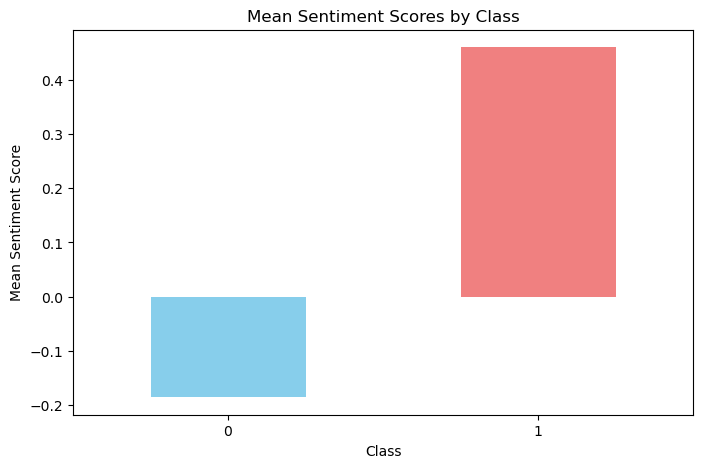

In [21]:
# Create a bar chart for mean sentiment scores by class
plt.figure(figsize=(8, 5))
mean_sentiment_by_class.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Mean Sentiment Scores by Class')
plt.xlabel('Class')
plt.ylabel('Mean Sentiment Score')
plt.xticks(rotation=0)
plt.show()

In [23]:
# Separate positive and negative reviews
positive_reviews_df = df_balanced[df_balanced['Label'] == 1]

In [24]:
negative_reviews_df = df_balanced[df_balanced['Label'] == 0]


In [25]:
# Display the first few rows of each DataFrame
print("\nPositive Reviews:")
print(positive_reviews_df.head())


Positive Reviews:
                                         Review  Label  \
1                   Good case, Excellent value.      1   
2                        Great for the jawbone.      1   
4                             The mic is great.      1   
7   If you are Razr owner...you must have this!      1   
10              And the sound quality is great.      1   

             Processed_Review  VADER_Sentiment  
1     good case, excel value.           0.8402  
2              great jawbone.           0.6249  
4                  mic great.           0.6249  
7   razr owner...y must this!           0.0000  
10       sound qualiti great.           0.6249  


In [26]:
print("\nNegative Reviews:")
print(negative_reviews_df.head())


Negative Reviews:
                                                Review  Label  \
743  Bought mainly for the charger, which broke soo...      0   
151                  Audio Quality is poor, very poor.      0   
767  I really wanted the Plantronics 510 to be the ...      0   
328                                      AMAZON SUCKS.      0   
217  I also didn't like the "on" button, it felt li...      0   

                                      Processed_Review  VADER_Sentiment  
743      bought mainli charger, broke soon purchasing.          -0.4215  
151                          audio qualiti poor, poor.          -0.7351  
767  realli want plantron 510 right one, mani issu ...           0.5927  
328                                      amazon sucks.          -0.2023  
217  also like "on" button, felt like would crack use.          -0.4973  


In [27]:
# Combine all reviews into a single text for positive and negative reviews
all_positive_reviews = ' '.join(positive_reviews_df['Review'])
all_negative_reviews = ' '.join(negative_reviews_df['Review'])

In [28]:
# Display the combined reviews
print("\nCombined Positive Reviews:")
print(all_positive_reviews[:500])  # Displaying the first 500 characters for brevity

print("\nCombined Negative Reviews:")
print(all_negative_reviews[:500])  # Displaying the first 500 characters for brevity



Combined Positive Reviews:
Good case, Excellent value. Great for the jawbone. The mic is great. If you are Razr owner...you must have this! And the sound quality is great. He was very impressed when going from the original battery to the extended battery. Very good quality though Highly recommend for any one who has a blue tooth phone. So Far So Good!. Works great!. I bought this to use with my Kindle Fire and absolutely loved it! I have yet to run this new battery below two bars and that's three days without charging. Gr

Combined Negative Reviews:
Bought mainly for the charger, which broke soon after purchasing. Audio Quality is poor, very poor. I really wanted the Plantronics 510 to be the right one, but it has too many issues for me.The good AMAZON SUCKS. I also didn't like the "on" button, it felt like it would crack with use. Improper description.... I had to return it. I get absolutely horrible reception in my apartment, where with other phones I have not had this problem. poor

In [29]:
from nltk.tokenize import word_tokenize

# Tokenize the combined positive and negative reviews
tokenized_positive_reviews = word_tokenize(all_positive_reviews)
tokenized_negative_reviews = word_tokenize(all_negative_reviews)

In [30]:
# Display the first few tokens
print("\nTokenized Positive Reviews:")
print(tokenized_positive_reviews[:20])  # Displaying the first 20 tokens for brevity

print("\nTokenized Negative Reviews:")
print(tokenized_negative_reviews[:20])  # Displaying the first 20 tokens for brevity


Tokenized Positive Reviews:
['Good', 'case', ',', 'Excellent', 'value', '.', 'Great', 'for', 'the', 'jawbone', '.', 'The', 'mic', 'is', 'great', '.', 'If', 'you', 'are', 'Razr']

Tokenized Negative Reviews:
['Bought', 'mainly', 'for', 'the', 'charger', ',', 'which', 'broke', 'soon', 'after', 'purchasing', '.', 'Audio', 'Quality', 'is', 'poor', ',', 'very', 'poor', '.']


In [31]:
# Remove stopwords from tokenized positive and negative reviews
filtered_positive_reviews = [word for word in tokenized_positive_reviews if word.lower() not in stop_words]
filtered_negative_reviews = [word for word in tokenized_negative_reviews if word.lower() not in stop_words]

In [32]:
# Display the first few tokens after removing stopwords
print("\nFiltered Positive Reviews (after removing stopwords):")
print(filtered_positive_reviews[:20])  # Displaying the first 20 tokens for brevity

print("\nFiltered Negative Reviews (after removing stopwords):")
print(filtered_negative_reviews[:20])  # Displaying the first 20 tokens for brevity


Filtered Positive Reviews (after removing stopwords):
['Good', 'case', ',', 'Excellent', 'value', '.', 'Great', 'jawbone', '.', 'mic', 'great', '.', 'Razr', 'owner', '...', 'must', '!', 'sound', 'quality', 'great']

Filtered Negative Reviews (after removing stopwords):
['Bought', 'mainly', 'charger', ',', 'broke', 'soon', 'purchasing', '.', 'Audio', 'Quality', 'poor', ',', 'poor', '.', 'really', 'wanted', 'Plantronics', '510', 'right', 'one']


In [33]:
# Calculate frequency distributions for filtered positive and negative reviews
freq_dist_positive = FreqDist(filtered_positive_reviews)
freq_dist_negative = FreqDist(filtered_negative_reviews)

In [34]:
# Display the most common words
print("\nTop 20 Most Common Words in Positive Reviews:")
print(freq_dist_positive.most_common(20))

print("\nTop 20 Most Common Words in Negative Reviews:")
print(freq_dist_negative.most_common(20))


Top 20 Most Common Words in Positive Reviews:
[('.', 440), (',', 149), ('!', 98), ('phone', 78), ('great', 62), ('good', 48), ('Great', 31), ('works', 31), ('quality', 30), ('product', 30), ('well', 30), ('headset', 29), ('sound', 24), ('price', 24), ('one', 22), ('use', 21), ("'s", 21), ('recommend', 20), ("'ve", 19), ('case', 18)]

Top 20 Most Common Words in Negative Reviews:
[('.', 460), (',', 144), ('phone', 73), ('!', 69), ("n't", 58), ('work', 23), ("'s", 22), ('product', 21), ('use', 20), ('battery', 19), ('ear', 18), ('money', 18), ('one', 17), ('would', 17), ('headset', 16), ('time', 15), ('could', 15), ('get', 14), ('quality', 14), ('service', 14)]


In [35]:
top_n = 10 

In [36]:
# Get the top 10 most frequent words from positive and negative reviews
top_positive_words = freq_dist_positive.most_common(top_n)
top_negative_words = freq_dist_negative.most_common(top_n)

In [37]:
# Display the top 10 most frequent words
print(f"\nTop {top_n} Most Frequent Words in Positive Reviews:")
print(top_positive_words)

print(f"\nTop {top_n} Most Frequent Words in Negative Reviews:")
print(top_negative_words)


Top 10 Most Frequent Words in Positive Reviews:
[('.', 440), (',', 149), ('!', 98), ('phone', 78), ('great', 62), ('good', 48), ('Great', 31), ('works', 31), ('quality', 30), ('product', 30)]

Top 10 Most Frequent Words in Negative Reviews:
[('.', 460), (',', 144), ('phone', 73), ('!', 69), ("n't", 58), ('work', 23), ("'s", 22), ('product', 21), ('use', 20), ('battery', 19)]


In [38]:
# Convert top N most frequent words to a DataFrame for visualization
df_top_positive_words = pd.DataFrame(top_positive_words, columns=['Word', 'Frequency_Positive'])
df_top_negative_words = pd.DataFrame(top_negative_words, columns=['Word', 'Frequency_Negative'])

In [39]:
# Merge the DataFrames on the 'Word' column
df_top_words = pd.merge(df_top_positive_words, df_top_negative_words, on='Word', how='outer')

In [40]:
# Fill NaN values with 0
df_top_words = df_top_words.fillna(0)

In [41]:
# Display the DataFrame
print("\nTop N Most Frequent Words DataFrame:")
print(df_top_words)


Top N Most Frequent Words DataFrame:
       Word  Frequency_Positive  Frequency_Negative
0         .               440.0               460.0
1         ,               149.0               144.0
2         !                98.0                69.0
3     phone                78.0                73.0
4     great                62.0                 0.0
5      good                48.0                 0.0
6     Great                31.0                 0.0
7     works                31.0                 0.0
8   quality                30.0                 0.0
9   product                30.0                21.0
10      n't                 0.0                58.0
11     work                 0.0                23.0
12       's                 0.0                22.0
13      use                 0.0                20.0
14  battery                 0.0                19.0


<Figure size 1200x600 with 0 Axes>

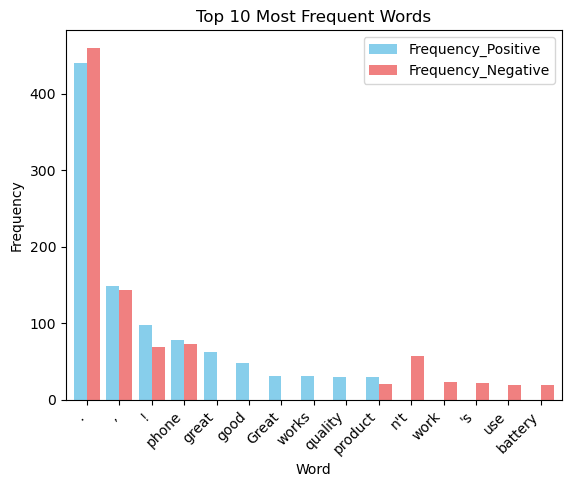

In [42]:
# Visualize the top N most frequent words using a bar chart
plt.figure(figsize=(12, 6))
df_top_words.plot(x='Word', kind='bar', width=0.8, color=['skyblue', 'lightcoral'])
plt.title(f'Top {top_n} Most Frequent Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.show()

In [43]:
# Plot frequency distributions for positive and negative reviews
plt.figure(figsize=(16, 8))

<Figure size 1600x800 with 0 Axes>

<Figure size 1600x800 with 0 Axes>

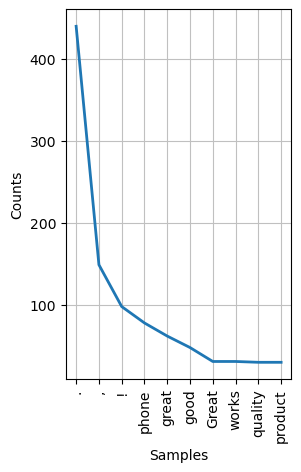

Text(0, 0.5, 'Frequency')

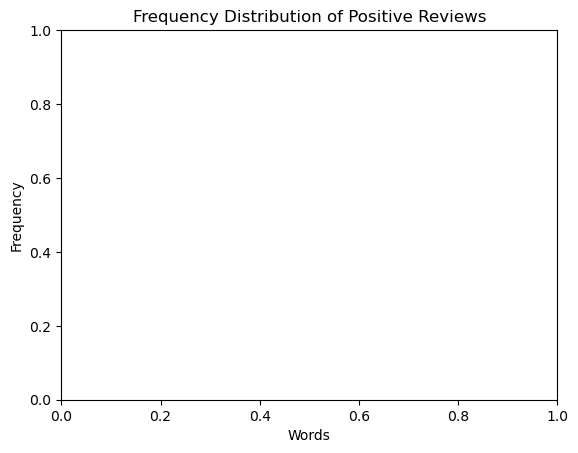

In [44]:
plt.subplot(1, 2, 1)
freq_dist_positive.plot(top_n, cumulative=False)
plt.title('Frequency Distribution of Positive Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')

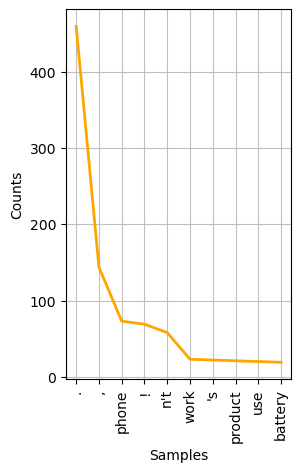

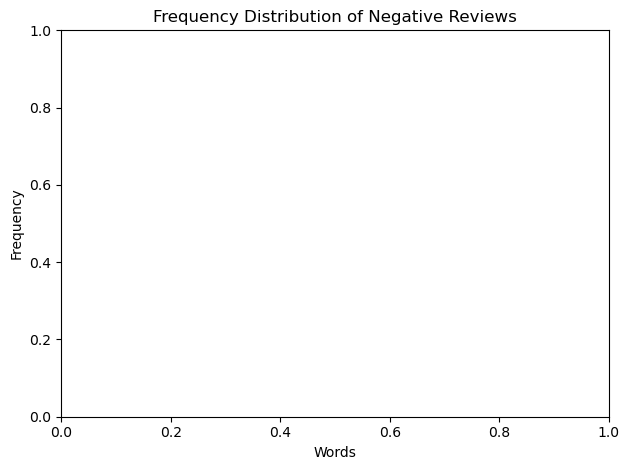

In [45]:
plt.subplot(1, 2, 2)
freq_dist_negative.plot(top_n, cumulative=False, color='orange')
plt.title('Frequency Distribution of Negative Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [22]:
# WordCloud Visualization
positive_words = ' '.join(df_balanced[df_balanced['Label'] == 1]['Processed_Review'])
negative_words = ' '.join(df_balanced[df_balanced['Label'] == 0]['Processed_Review'])

In [46]:
wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_words)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_words)

(-0.5, 799.5, 399.5, -0.5)

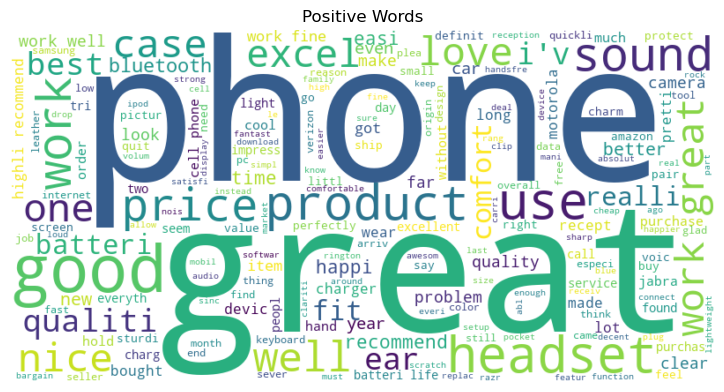

In [47]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Positive Words')
plt.axis('off')

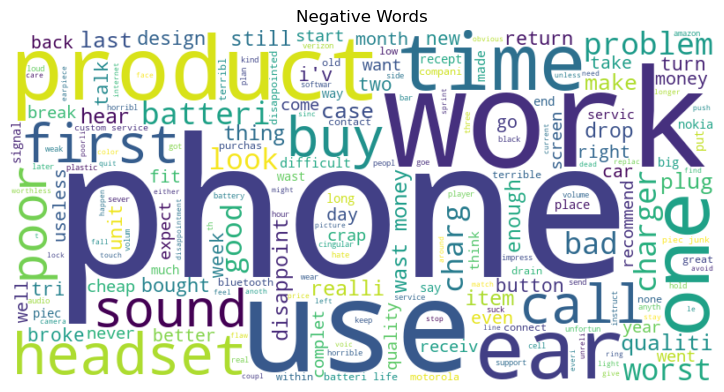

In [48]:
plt.figure(figsize=(20, 15))
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Negative Words')
plt.axis('off')
plt.show()